In [48]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, RANSACRegressor

from scipy import stats

import joblib

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date, date2num
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

In [49]:
QS_fname = 'trainedOnQS_predictOnQS_forAllData.nc'
AS_fname = 'trainedOnQS_predictOnASCAT_forAllData.nc'
ds = xr.open_dataset(QS_fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
ds_AS = xr.open_dataset(AS_fname)

In [50]:
data = ds.to_dataframe()
df = data.copy()

In [51]:
data_AS = ds_AS.to_dataframe()
df_AS = data_AS.copy()

In [52]:
ds

<xarray.Dataset> Size: 248MB
Dimensions:                                                     (count: 266786)
Coordinates:
  * count                                                       (count) int64 2MB ...
Data variables: (12/125)
    Wind Direction (TAO)                                        (count) float32 1MB ...
    WDIR_QC                                                     (count) float32 1MB ...
    WDIR_DM                                                     (count) |S1 267kB ...
    Wind Speed (TAO)                                            (count) float32 1MB ...
    WSPD_QC                                                     (count) float32 1MB ...
    WSPD_DM                                                     (count) |S1 267kB ...
    ...                                                          ...
    Meridional Wind Speed Difference (QuikSCAT - TAO) absolute  (count) float64 2MB ...
    SST - AIRT                                                  (count) float32 1MB ...
    predicted_label                                             (count) int64 2MB ...
    label                                                       (count) int64 2MB ...
    GoodBad                                                     (count) <U4 4MB ...
    mean_WVEL                                                   (count) float64 2MB ...

In [53]:
ds_AS

<xarray.Dataset> Size: 48MB
Dimensions:                                                  (count: 70596)
Coordinates:
  * count                                                    (count) int64 565kB ...
Data variables: (12/94)
    Wind Direction (TAO)                                     (count) float32 282kB ...
    WDIR_QC                                                  (count) float32 282kB ...
    WDIR_DM                                                  (count) |S1 71kB ...
    Wind Speed (TAO)                                         (count) float32 282kB ...
    WSPD_QC                                                  (count) float32 282kB ...
    WSPD_DM                                                  (count) |S1 71kB ...
    ...                                                       ...
    sin(Direction Difference (ASCAT - TAO)) absolute         (count) float64 565kB ...
    Zonal Wind Speed Difference (ASCAT - TAO) absolute       (count) float64 565kB ...
    Meridional Wind Speed Difference (ASCAT - TAO) absolute  (count) float64 565kB ...
    SST - AIRT                                               (count) float32 282kB ...
    predicted_label                                          (count) int64 565kB ...
    label                                                    (count) int64 565kB ...

In [54]:
df['label'] = df['label'] + 1
df_AS['label'] = df_AS['label'] + 1

In [55]:
def plotQS(subDF, axes, label_val = 'label'):
    Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
    Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    QS = Ux_QS + 1j * Uy_QS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = QS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF[label_val] == 0]
    subDF = subDF.loc[subDF[label_val] == 1]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['QS_TIME']))
        endDates.append(np.max(ssubDF['QS_TIME']))
        
        x = ((np.array(ssubDF['QS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['QS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['QS_TIME'], Y, color='k')
        
        y -= Y #- np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['QS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (QuikSCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['QS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['QS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['QS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (QS/TAO)')
    axes[1].set_title('Difference in wind direction (QS - TAO)')
    axes[2].set_title('Difference in wind direction (QS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')


In [56]:
def plotAS(subDF, axes, label_val = 'label'):
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF[label_val] == 0]
    subDF = subDF.loc[subDF[label_val] == 1]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['AS_TIME']))
        endDates.append(np.max(ssubDF['AS_TIME']))
        
        x = ((np.array(ssubDF['AS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['AS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['AS_TIME'], Y, color='k')
        
        y -= Y #(Y - np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['AS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (ASCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['AS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['AS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['AS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['AS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['AS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (AS/TAO)')
    axes[1].set_title('Difference in wind direction (AS - TAO)')
    axes[2].set_title('Difference in wind direction (AS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')

In [57]:
def plotSusanLikeWithCorrectedAngle(SUBDF, SUBDF_AS, lat, lon, suffix='all', label_val = 'label'):

    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return None


    subDF_AS = SUBDF_AS.loc[SUBDF_AS['LATITUDE'] == lat]
    subDF_AS = subDF_AS.loc[SUBDF_AS['LONGITUDE'] == (lon+360)%360]

    if len(subDF_AS.index) <1:
        return None
        
    fig, axess = plt.subplots(nrows=3, ncols=2, figsize=(20,12))

    axes = axess[:,0]
    plotQS(subDF, axes, label_val = label_val)

    axes = axess[:,1]
    plotAS(subDF_AS, axes, label_val = label_val)

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    
    
    title = f'images/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [58]:
def plotSusanLikeWithCorrectedAngleGreyBad(SUBDF, lat, lon, suffix='all', label_val = 'label'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return
    
    Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
    Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    QS = Ux_QS + 1j * Uy_QS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = QS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]


    subDF2 = subDF.loc[subDF[label_val] == 0]
    subDF = subDF.loc[subDF[label_val] == 1]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))
    startDates = []
    endDates = []
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,12))
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        
        startDates.append(np.min(ssubDF['QS_TIME']))
        endDates.append(np.max(ssubDF['QS_TIME']))
        
        x = ((np.array(ssubDF['QS_TIME']) - np.datetime64('2000-01-01T00:00:00'))/np.timedelta64(1,'m')).reshape(-1,1)    
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        if len(x) <2:
            continue
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[0].plot(ssubDF['QS_TIME'], Y, color='k')    
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)
    
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[1].plot(ssubDF['QS_TIME'], Y, color='k')
        
        y -= (Y - np.mean(Y)) 
        ransac.fit(x, y)
        Y = ransac.predict(x)
        axes[2].plot(ssubDF['QS_TIME'], Y, color='k')
        
        # ssubDF.loc[:,'corrected_angle_diff'] = y[:,0]
        # ssubDF.loc[:,'corrected_angle'] = ssubDF['Wind Direction (QuikSCAT)'] - ssubDF['corrected_angle_diff']

        # Ux_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(ssubDF['corrected_angle']))
        # Uy_TAO = ssubDF['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(ssubDF['corrected_angle']))
        # subDF.loc[subDF['Deployment index'] == dep, 'Zonal Neutral Wind Speed (TAO) aft. correc.'] = Ux_TAO
        # subDF.loc[subDF['Deployment index'] == dep, 'Meridional Neutral Wind Speed (TAO) aft. correc.'] = Uy_TAO
        subDF.loc[subDF['Deployment index'] == dep, 'corrected_angle_diff'] = y[:,0]
        
    ax = axes[0]
    ax.scatter(subDF['QS_TIME'], subDF['ratio'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['ratio'], c = 'grey', s = 0.4)
    
    ax = axes[1]
    ax.scatter(subDF['QS_TIME'], subDF['angle_diff'], c = 'r', s = 0.2)
    ax.scatter(subDF2['QS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    ax = axes[2]
    ax.scatter(subDF['QS_TIME'], subDF['corrected_angle_diff'], c = 'r', s = 0.2)
    #ax.scatter(subDF2['QS_TIME'], subDF2['angle_diff'], c = 'grey', s = 0.4)

    
    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        axes[0].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[1].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        axes[2].axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    axes[0].set_ylim(0,2)
    axes[1].set_ylim(-50,50)
    axes[2].set_ylim(-50,50)
    
    axes[0].set_title('Ratio of wind speeds (QS/TAO)')
    axes[1].set_title('Difference in wind direction (QS - TAO)')
    axes[2].set_title('Difference in wind direction (QS - TAO) after correction from robust regression fit')

    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    axes[2].grid(axis='y')
    
    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'
    
    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'
    title = f'T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_{suffix}.png'
    plt.savefig(title, dpi = 100)
    plt.close()

In [59]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

In [60]:
# subDF = df.loc[df['predicted_rain_flag'] == 0]
# subDF = subDF.loc[subDF[label_val] == 1]

# subDF_AS = df_AS.loc[df_AS['predicted_rain_flag'] == 0]
# subDF_AS = subDF_AS.loc[subDF_AS[label_val] == 0]

# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithoutCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithoutCorrection')

# for i in range(ntasks):
#     lat = taskList[i][0]
#     lon = taskList[i][1]
#     plotSusanLikeWithCorrectedAngle(subDF, lat, lon, suffix='dryAndGoodWithAngleCorrection')

for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    plotSusanLikeWithCorrectedAngle(df, df_AS, lat, lon, suffix='dryAndGoodWithAngleCorrection_origLabel', label_val = 'label')

/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/2737607455.py:11: RuntimeWarning: divide by zero encountered in divide
  r = AS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1175733913.py:11:

In [43]:
from scipy.stats import t

def calculate_stdErr_and_pval(x, y, Y, slope):
    RSS = np.sum((Y - y)**2)
    deg_of_freedom = len(y)-2
    sigma_hat_sq = RSS/(deg_of_freedom)
    std_err = np.sqrt(sigma_hat_sq/(np.sum( (x - np.mean(x))**2) 
                                   ))
    #print('RSS, std_err', RSS, std_err)
    #print(np.min(x), np.max(x))
    #print(np.sum( (x - np.mean(x))**2))
    t_stat = slope/(std_err)
    p_value = 2 * (1 - t.cdf(abs(t_stat), deg_of_freedom))
    return std_err, p_value

def getSlopeInterceptOffsetSpeedRatioDirectionDiff(SUBDF, lat, lon, label_val = 'label'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <1:
        return None
    
    Ux_QS = np.array(subDF['Zonal Wind Speed (QuikSCAT)'])
    Uy_QS = np.array(subDF['Meridional Wind Speed (QuikSCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    QS = Ux_QS + 1j * Uy_QS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = QS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio
    subDF['speed_diff'] = subDF['Wind Speed (QuikSCAT)'] - subDF['Neutral Wind Speed at 10m (TAO)']

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF[label_val] == 0]
    subDF = subDF.loc[subDF[label_val] == 1]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))

    dep_indx =[]
    startDates = []
    endDates = []
    
    speedRatio_slopes = []
    speedRatio_intercepts = []
    speedRatio_offsets = []
    speedRatio_r_value = []
    speedRatio_p_value = []
    speedRatio_std_err = []

    speedDiff_slopes = []
    speedDiff_intercepts = []
    speedDiff_offsets = []
    speedDiff_r_value = []
    speedDiff_p_value = []
    speedDiff_std_err = []

    direcDiff_slopes = []
    direcDiff_intercepts = []
    direcDiff_offsets = []
    direcDiff_r_value = []
    direcDiff_p_value = []
    direcDiff_std_err = []
        
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        if len(ssubDF) <5:
            continue

        startDates.append(pd.to_datetime(np.min(ssubDF['QS_TIME'])))
        endDates.append(pd.to_datetime(np.max(ssubDF['QS_TIME'])))

        ### Rergression for speed ratio
        x = ( (np.array(ssubDF['QS_TIME']) - np.datetime64(np.min(ssubDF['QS_TIME'])))/np.timedelta64(1,'D')).reshape(-1,1)
        x[x<1] = 0
        #print('np.min(x), np.max(x)', np.min(x), np.max(x))
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        #print('speed ratio np.min(y), np.max(y)', np.min(y), np.max(y))

        dep_indx.append(dep)
            
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        ## axes[0].plot(ssubDF['QS_TIME'], Y, color='k') 

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedRatio_slopes.append(slope)
        speedRatio_intercepts.append(intercept)
        speedRatio_offsets.append(np.mean(Y))

        std_err, p_value = calculate_stdErr_and_pval(x[:,0], y[:,0], Y[:,0], slope)
        
        speedRatio_r_value.append(r_value)
        speedRatio_p_value.append(p_value)
        speedRatio_std_err.append(std_err)


        ### Regression for speed difference
        y = np.array(ssubDF['speed_diff']).reshape(-1,1)

        #print('speed diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['QS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedDiff_slopes.append(slope)
        speedDiff_intercepts.append(intercept)
        speedDiff_offsets.append(np.mean(Y))

        std_err, p_value = calculate_stdErr_and_pval(x[:,0], y[:,0], Y[:,0], slope)
        
        speedDiff_r_value.append(r_value)
        speedDiff_p_value.append(p_value)
        speedDiff_std_err.append(std_err)


        ### Regression for direction difference
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)

        #print('direction diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['QS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        direcDiff_slopes.append(slope)
        direcDiff_intercepts.append(intercept)
        direcDiff_offsets.append(np.mean(Y))
        direcDiff_r_value.append(r_value)
        direcDiff_p_value.append(p_value)
        direcDiff_std_err.append(std_err)

    latVals = [lat for i in dep_indx]
    lonVals = [(lon+360)%360 for i in dep_indx]

    # print('lat, lon', lat, lon)

    # print('latVals', len(latVals), '\n',
    #       'lonVals', len(lonVals), '\n',
    #       'dep_indx', len(dep_indx), '\n',
    #       'startDates', len(startDates), '\n',
    #       'endDates', len(endDates), '\n',
    #       'speedRatio_slopes', len(speedRatio_slopes), '\n',
    #       'speedRatio_intercepts', len(speedRatio_intercepts), '\n',
    #       'speedRatio_offsets', len(speedRatio_offsets), '\n',
    #       'speedRatio_r_value', len(speedRatio_r_value), '\n',
    #       'speedRatio_p_value', len(speedRatio_p_value), '\n',
    #       'speedRatio_std_err', len(speedRatio_std_err), '\n',
    #       'direcDiff_slopes', len(direcDiff_slopes), '\n',
    #       'direcDiff_intercepts', len(direcDiff_intercepts), '\n',
    #       'direcDiff_offsets', len(direcDiff_offsets), '\n',
    #       'direcDiff_r_value', len(direcDiff_r_value), '\n',
    #       'direcDiff_p_value', len(direcDiff_p_value), '\n',
    #       'direcDiff_std_err', len(direcDiff_std_err), '\n')

    infoDict = {'LATITUDE': latVals,
                'LONGITUDE': lonVals,
                'Deployments': dep_indx,
                'Start Dates': startDates,
                'End Dates': endDates,
                'speedRatio_slopes': speedRatio_slopes,
                'speedRatio_intercepts': speedRatio_intercepts,
                'speedRatio_offsets': speedRatio_offsets,
                'speedRatio_r_value': speedRatio_r_value,
                'speedRatio_p_value': speedRatio_p_value,
                'speedRatio_std_err': speedRatio_std_err,
                'speedDiff_slopes': speedDiff_slopes,
                'speedDiff_intercepts': speedDiff_intercepts,
                'speedDiff_offsets': speedDiff_offsets,
                'speedDiff_r_value': speedDiff_r_value,
                'speedDiff_p_value': speedDiff_p_value,
                'speedDiff_std_err': speedDiff_std_err,
                'direcDiff_slopes': direcDiff_slopes,
                'direcDiff_intercepts': direcDiff_intercepts,
                'direcDiff_offsets': direcDiff_offsets,
                'direcDiff_r_value': direcDiff_r_value,
                'direcDiff_p_value': direcDiff_p_value,
                'direcDiff_std_err': direcDiff_std_err}

    outDF = pd.DataFrame(infoDict, columns = ['LATITUDE',
                                            'LONGITUDE',
                                            'Deployments',
                                            'Start Dates',
                                            'End Dates',
                                            'speedRatio_slopes',
                                            'speedRatio_intercepts',
                                            'speedRatio_offsets',
                                            'speedRatio_r_value',
                                            'speedRatio_p_value',
                                            'speedRatio_std_err',
                                            'speedDiff_slopes',
                                            'speedDiff_intercepts',
                                            'speedDiff_offsets',
                                            'speedDiff_r_value',
                                            'speedDiff_p_value',
                                            'speedDiff_std_err',
                                            'direcDiff_slopes',
                                            'direcDiff_intercepts',
                                            'direcDiff_offsets',
                                            'direcDiff_r_value',
                                            'direcDiff_p_value',
                                            'direcDiff_std_err'])
    return outDF
        

In [44]:
def getSlopeInterceptOffsetSpeedRatioDirectionDiff_AS(SUBDF, lat, lon, label_val = 'label'):
    subDF = SUBDF.loc[SUBDF['LATITUDE'] == lat]
    subDF = subDF.loc[SUBDF['LONGITUDE'] == (lon+360)%360]

    if len(subDF.index) <5:
        return None
    
    Ux_AS = np.array(subDF['Zonal Wind Speed (ASCAT)'])
    Uy_AS = np.array(subDF['Meridional Wind Speed (ASCAT)'])
    
    Ux_TAO = np.array(subDF['Zonal Neutral Wind Speed (TAO)'])
    Uy_TAO = np.array(subDF['Meridional Neutral Wind Speed (TAO)'])
    
    AS = Ux_AS + 1j * Uy_AS
    TAO = Ux_TAO + 1j *Uy_TAO
    
    r = AS/TAO
    angle = np.angle(r, deg=True)
    ratio = np.abs(r)
    subDF['angle_diff'] = angle
    subDF['ratio'] = ratio
    subDF['speed_diff'] = subDF['Wind Speed (ASCAT)'] - subDF['Neutral Wind Speed at 10m (TAO)']

    subDF['corrected_angle_diff'] = angle
    subDF['Zonal Neutral Wind Speed (TAO) aft. correc.'] = subDF['Zonal Neutral Wind Speed (TAO)']
    subDF['Meridional Neutral Wind Speed (TAO) aft. correc.'] = subDF['Meridional Neutral Wind Speed (TAO)']

    mask = np.logical_or(np.isnan(ratio), abs(ratio) > 100)
    subDF = subDF.loc[~mask]

    subDF2 = subDF.loc[subDF[label_val] == 0]
    subDF = subDF.loc[subDF[label_val] == 1]
    
    deployments = subDF['Deployment index']
    dep_labels = np.unique(np.array(deployments))

    dep_indx =[]
    startDates = []
    endDates = []
    
    speedRatio_slopes = []
    speedRatio_intercepts = []
    speedRatio_offsets = []
    speedRatio_r_value = []
    speedRatio_p_value = []
    speedRatio_std_err = []

    speedDiff_slopes = []
    speedDiff_intercepts = []
    speedDiff_offsets = []
    speedDiff_r_value = []
    speedDiff_p_value = []
    speedDiff_std_err = []

    direcDiff_slopes = []
    direcDiff_intercepts = []
    direcDiff_offsets = []
    direcDiff_r_value = []
    direcDiff_p_value = []
    direcDiff_std_err = []
        
    
    for dep in dep_labels:
        ssubDF = subDF.loc[subDF['Deployment index'] == dep]
        if len(ssubDF) < 5:
            continue

        startDates.append(pd.to_datetime(np.min(ssubDF['AS_TIME'])))
        endDates.append(pd.to_datetime(np.max(ssubDF['AS_TIME'])))

        ### Rergression for speed ratio
        x = ( (np.array(ssubDF['AS_TIME']) - np.datetime64(np.min(ssubDF['AS_TIME'])))/np.timedelta64(1,'D')).reshape(-1,1)
        x[x<1] = 0
        #print('np.min(x), np.max(x)', np.min(x), np.max(x))
        y = np.array(ssubDF['ratio']).reshape(-1,1)

        #print('speed ratio np.min(y), np.max(y)', np.min(y), np.max(y))

        dep_indx.append(dep)
            
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        ## axes[0].plot(ssubDF['AS_TIME'], Y, color='k') 

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedRatio_slopes.append(slope)
        speedRatio_intercepts.append(intercept)
        speedRatio_offsets.append(np.mean(Y))

        std_err, p_value = calculate_stdErr_and_pval(x[:,0], y[:,0], Y[:,0], slope)
        
        speedRatio_r_value.append(r_value)
        speedRatio_p_value.append(p_value)
        speedRatio_std_err.append(std_err)


        ### Regression for speed difference
        y = np.array(ssubDF['speed_diff']).reshape(-1,1)

        #print('speed diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['AS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        speedDiff_slopes.append(slope)
        speedDiff_intercepts.append(intercept)
        speedDiff_offsets.append(np.mean(Y))

        std_err, p_value = calculate_stdErr_and_pval(x[:,0], y[:,0], Y[:,0], slope)
        
        speedDiff_r_value.append(r_value)
        speedDiff_p_value.append(p_value)
        speedDiff_std_err.append(std_err)


        ### Regression for direction difference
        y = np.array(ssubDF['angle_diff']).reshape(-1,1)

        #print('direction diff np.min(y), np.max(y)', np.min(y), np.max(y))
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(x, y)

        ### plotting line
        Y = ransac.predict(x)
        #axes[1].plot(ssubDF['AS_TIME'], Y, color='k')

        slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], Y[:,0])
        direcDiff_slopes.append(slope)
        direcDiff_intercepts.append(intercept)
        direcDiff_offsets.append(np.mean(Y))
        direcDiff_r_value.append(r_value)
        direcDiff_p_value.append(p_value)
        direcDiff_std_err.append(std_err)

    latVals = [lat for i in dep_indx]
    lonVals = [(lon+360)%360 for i in dep_indx]

    infoDict = {'LATITUDE': latVals,
                'LONGITUDE': lonVals,
                'Deployments': dep_indx,
                'Start Dates': startDates,
                'End Dates': endDates,
                'speedRatio_slopes': speedRatio_slopes,
                'speedRatio_intercepts': speedRatio_intercepts,
                'speedRatio_offsets': speedRatio_offsets,
                'speedRatio_r_value': speedRatio_r_value,
                'speedRatio_p_value': speedRatio_p_value,
                'speedRatio_std_err': speedRatio_std_err,
                'speedDiff_slopes': speedDiff_slopes,
                'speedDiff_intercepts': speedDiff_intercepts,
                'speedDiff_offsets': speedDiff_offsets,
                'speedDiff_r_value': speedDiff_r_value,
                'speedDiff_p_value': speedDiff_p_value,
                'speedDiff_std_err': speedDiff_std_err,
                'direcDiff_slopes': direcDiff_slopes,
                'direcDiff_intercepts': direcDiff_intercepts,
                'direcDiff_offsets': direcDiff_offsets,
                'direcDiff_r_value': direcDiff_r_value,
                'direcDiff_p_value': direcDiff_p_value,
                'direcDiff_std_err': direcDiff_std_err}

    outDF = pd.DataFrame(infoDict, columns = ['LATITUDE',
                                            'LONGITUDE',
                                            'Deployments',
                                            'Start Dates',
                                            'End Dates',
                                            'speedRatio_slopes',
                                            'speedRatio_intercepts',
                                            'speedRatio_offsets',
                                            'speedRatio_r_value',
                                            'speedRatio_p_value',
                                            'speedRatio_std_err',
                                            'speedDiff_slopes',
                                            'speedDiff_intercepts',
                                            'speedDiff_offsets',
                                            'speedDiff_r_value',
                                            'speedDiff_p_value',
                                            'speedDiff_std_err',
                                            'direcDiff_slopes',
                                            'direcDiff_intercepts',
                                            'direcDiff_offsets',
                                            'direcDiff_r_value',
                                            'direcDiff_p_value',
                                            'direcDiff_std_err'])
    return outDF
        

In [45]:
import pandas as pd
allDataDF = []
for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    infoDF = getSlopeInterceptOffsetSpeedRatioDirectionDiff(df, lat, lon, label_val = 'predicted_label')
    if infoDF is not None:
        allDataDF.append(infoDF)

allDataDFconcated = pd.concat(allDataDF, axis=0, join='outer')
#allDataDFconcated = allDataDFconcated.dropna(how='any')


allDataDF = []
for i in range(ntasks):
    lat = taskList[i][0]
    lon = taskList[i][1]
    infoDF = getSlopeInterceptOffsetSpeedRatioDirectionDiff_AS(df_AS, lat, lon, label_val = 'predicted_label')
    if infoDF is not None:
        allDataDF.append(infoDF)

allDataDFconcated_AS = pd.concat(allDataDF, axis=0, join='outer')
#allDataDFconcated_AS= allDataDFconcated_AS.dropna(how='any')

/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: divide by zero encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: RuntimeWarning: invalid value encountered in divide
  r = QS/TAO
/tmp/ipykernel_1561118/1797634129.py:32: 

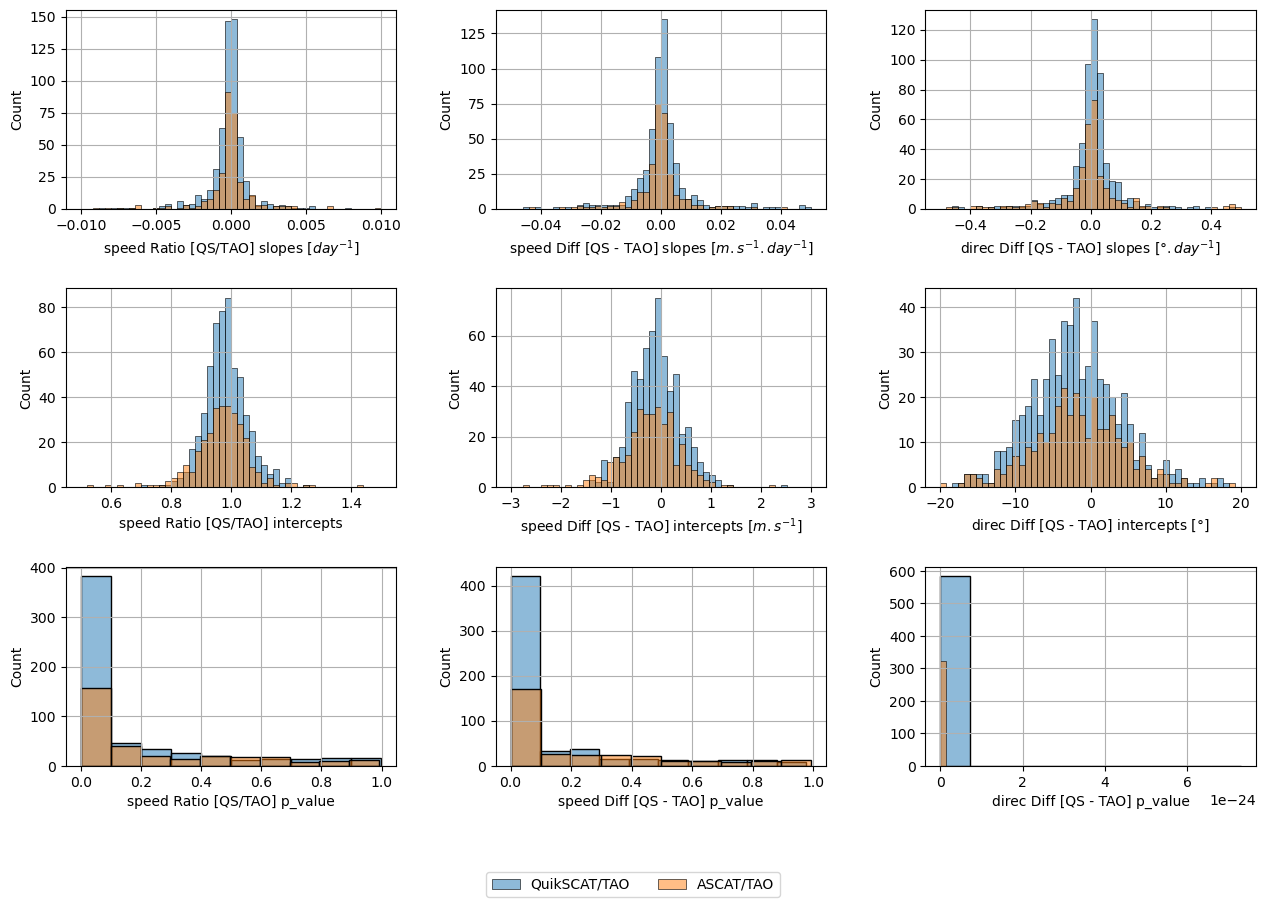

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

test = allDataDFconcated.loc[abs(allDataDFconcated['LATITUDE']) <= 2]
test1 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] > 2]
test2 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] < -2]

xlabel1 = 'speedRatio_slopes'
xlabel2 = 'speedDiff_slopes'
xlabel3 = 'direcDiff_slopes'
xlabel4 = 'speedRatio_intercepts'
xlabel5 = 'speedDiff_intercepts'
xlabel6 = 'direcDiff_intercepts'
xlabel7 = 'speedRatio_p_value'
xlabel8 = 'speedDiff_p_value'
xlabel9 = 'direcDiff_p_value'


fig_xlabel1 = 'speed Ratio [QS/TAO] slopes [$day^{-1}$]'
fig_xlabel2 = 'speed Diff [QS - TAO] slopes [$m.s^{-1}.day^{-1}$]'
fig_xlabel3 = 'direc Diff [QS - TAO] slopes [$\degree.day^{-1}$]'
fig_xlabel4 = 'speed Ratio [QS/TAO] intercepts'
fig_xlabel5 = 'speed Diff [QS - TAO] intercepts [$m.s^{-1}$]'
fig_xlabel6 = 'direc Diff [QS - TAO] intercepts [$\degree$]'
fig_xlabel7 = 'speed Ratio [QS/TAO] p_value'
fig_xlabel8 = 'speed Diff [QS - TAO] p_value'
fig_xlabel9 = 'direc Diff [QS - TAO] p_value'

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 9), sharex=False, sharey=False)

labels = ['QuikSCAT/TAO', 'ASCAT/TAO'] #[r'within $\pm 2\degree$ latitude', r'$ > 2\degree$ latitude', r'$< -2\degree$ latitude', 'all locations']
xlabels = [xlabel1, xlabel2, xlabel3, xlabel4, xlabel5, xlabel6, xlabel7, xlabel8, xlabel9]
fig_xlabels = [fig_xlabel1, fig_xlabel2, fig_xlabel3, fig_xlabel4, fig_xlabel5, fig_xlabel6, fig_xlabel7, fig_xlabel8, fig_xlabel9]
xlims = [(-0.02, 0.02), (-0.05, 0.05), (-1, 1), None, None, (-30,25), None, None, None]

binEdges = [np.linspace(-0.01, 0.01, 51), 
            np.linspace(-0.05, 0.05, 51),
            np.linspace(-0.5, 0.5, 51),
            np.linspace(0.5, 1.5, 51),
            np.linspace(-3, 3, 51),
            np.linspace(-20, 20, 51), 
            10, #np.linspace(0,0.001, 51), 
            10, #np.linspace(0,0.001, 51), 
            10, #np.linspace(0,0.001, 51)
            ]

for i, ax in enumerate(axes.flat):
    #sns.kdeplot(test, x=xlabels[i], ax=ax, label=labels[0])
    #sns.kdeplot(test1, x=xlabels[i], ax=ax, label=labels[1])
    #sns.kdeplot(test2, x=xlabels[i], ax=ax, label=labels[2])
    sns.histplot(allDataDFconcated, x=xlabels[i], bins = binEdges[i], ax=ax, label=labels[0], alpha = 0.5)
    sns.histplot(allDataDFconcated_AS, x=xlabels[i], bins = binEdges[i], ax=ax, label=labels[1], alpha = 0.5)
    
    # if xlims[i] is not None:
    #     ax.set_xlim(xlims[i])
    
    ax.set_xlabel(fig_xlabels[i])
    ax.grid()

# Create a single legend below all plots
handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize='medium')

# Adjust layout to make space for the legend
plt.subplots_adjust(left= 0.05, hspace=0.4, wspace=0.3, bottom=0.15, top=0.99)

plt.savefig('pdf_of_slopes_intercepts_from_timeSeries.pdf', dpi=100)


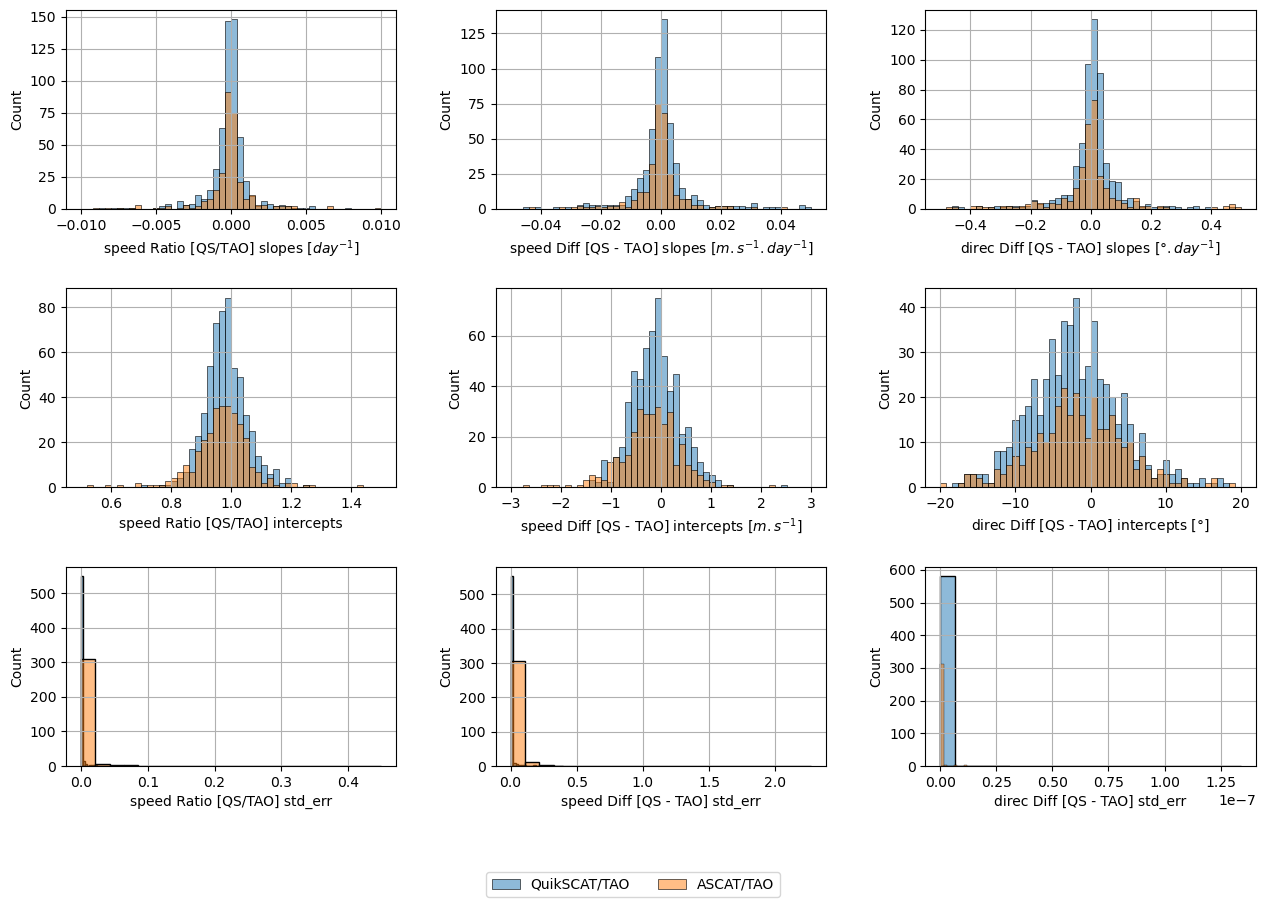

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

test = allDataDFconcated.loc[abs(allDataDFconcated['LATITUDE']) <= 2]
test1 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] > 2]
test2 = allDataDFconcated.loc[allDataDFconcated['LATITUDE'] < -2]

xlabel1 = 'speedRatio_slopes'
xlabel2 = 'speedDiff_slopes'
xlabel3 = 'direcDiff_slopes'
xlabel4 = 'speedRatio_intercepts'
xlabel5 = 'speedDiff_intercepts'
xlabel6 = 'direcDiff_intercepts'
xlabel7 = 'speedRatio_std_err'
xlabel8 = 'speedDiff_std_err'
xlabel9 = 'direcDiff_std_err'


fig_xlabel1 = 'speed Ratio [QS/TAO] slopes [$day^{-1}$]'
fig_xlabel2 = 'speed Diff [QS - TAO] slopes [$m.s^{-1}.day^{-1}$]'
fig_xlabel3 = 'direc Diff [QS - TAO] slopes [$\degree.day^{-1}$]'
fig_xlabel4 = 'speed Ratio [QS/TAO] intercepts'
fig_xlabel5 = 'speed Diff [QS - TAO] intercepts [$m.s^{-1}$]'
fig_xlabel6 = 'direc Diff [QS - TAO] intercepts [$\degree$]'
fig_xlabel7 = 'speed Ratio [QS/TAO] std_err'
fig_xlabel8 = 'speed Diff [QS - TAO] std_err'
fig_xlabel9 = 'direc Diff [QS - TAO] std_err'

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 9), sharex=False, sharey=False)

labels = ['QuikSCAT/TAO', 'ASCAT/TAO'] #[r'within $\pm 2\degree$ latitude', r'$ > 2\degree$ latitude', r'$< -2\degree$ latitude', 'all locations']
xlabels = [xlabel1, xlabel2, xlabel3, xlabel4, xlabel5, xlabel6, xlabel7, xlabel8, xlabel9]
fig_xlabels = [fig_xlabel1, fig_xlabel2, fig_xlabel3, fig_xlabel4, fig_xlabel5, fig_xlabel6, fig_xlabel7, fig_xlabel8, fig_xlabel9]
xlims = [(-0.02, 0.02), (-0.05, 0.05), (-1, 1), None, None, (-30,25), None, None, None]

binEdges = [np.linspace(-0.01, 0.01, 51), 
            np.linspace(-0.05, 0.05, 51),
            np.linspace(-0.5, 0.5, 51),
            np.linspace(0.5, 1.5, 51),
            np.linspace(-3, 3, 51),
            np.linspace(-20, 20, 51), 
            21, #np.linspace(0,0.001, 51), 
            21, #np.linspace(0,0.001, 51), 
            21 #np.linspace(0,0.001, 51)
            ]

for i, ax in enumerate(axes.flat):
    #sns.kdeplot(test, x=xlabels[i], ax=ax, label=labels[0])
    #sns.kdeplot(test1, x=xlabels[i], ax=ax, label=labels[1])
    #sns.kdeplot(test2, x=xlabels[i], ax=ax, label=labels[2])
    sns.histplot(allDataDFconcated, x=xlabels[i], bins = binEdges[i], ax=ax, label=labels[0], alpha = 0.5)
    sns.histplot(allDataDFconcated_AS, x=xlabels[i], bins = binEdges[i], ax=ax, label=labels[1], alpha = 0.5)
    
    # if xlims[i] is not None:
    #     ax.set_xlim(xlims[i])
    
    ax.set_xlabel(fig_xlabels[i])
    ax.grid()

# Create a single legend below all plots
handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize='medium')

# Adjust layout to make space for the legend
plt.subplots_adjust(left= 0.05, hspace=0.4, wspace=0.3, bottom=0.15, top=0.99)

#plt.savefig('pdf_of_slopes_intercepts_from_timeSeries.pdf', dpi=100)


In [ ]:
fig, ax = plt.subplots()
sns.histplot(allDataDFconcated_AS, x = 'direcDiff_std_err', ax = ax)
ax.set_ylim([0,100])

In [ ]:
fig, ax = plt.subplots()
sns.histplot(allDataDFconcated, x = 'direcDiff_std_err')
ax.set_ylim([0,100])